In [1]:
# importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

from scipy import stats
from scipy.stats import norm

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

import re

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

# setting some globl config
plt.style.use('fivethirtyeight')
cust_color = ['#fdc029',
'#f7c14c',
'#f0c268',
'#e8c381',
'#dfc498',
'#d4c5af',
'#c6c6c6',
'#a6a6a8',
'#86868a',
'#68686d',
'#4b4c52',
'#303138',
'#171820',
]
plt.rcParams['figure.figsize'] = (18,14)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.color"] = cust_color[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["font.family"] = "monospace"

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def one_hot_count(df: pd.DataFrame, values:list,text:str, colors=None, shift_text=200, x_freq=2000, title=None, fontsize=12):
    """A function for plotting multi choice questions."""
    
    df2= df.copy()
    for val in values:
        df2[text+val]=df2[text+val].fillna('unk')
        df2[text+val]=df2[text+val].apply(lambda x: x.strip())
        df2[text+val]=df2[text+val].map({val:1, 'unk':0})
    df2.columns = df2.columns.str.replace(text, '', regex=False)
    
    counts = {}
    for col in values:
        counts[col]=df2[col].sum()
    counts = pd.DataFrame.from_dict(counts, orient='index')
    
    fig, ax = plt.subplots(figsize=(18, 14))
    counts = counts.rename(columns={0: 'Count'}).sort_values(by='Count',ascending=False)
    sns.barplot(y=counts.index,
                    x=counts['Count'], palette=colors, edgecolor='black', saturation = 1.5, linewidth = 1.5)
    for n, i in enumerate(counts['Count']):    
        ax.text(counts['Count'][n]+shift_text, 
                n, #Y location
                s=f'{round(counts.Count[n]/len(df2)*100,1)}%', 
                va='center', 
                ha='right', 
                color='white', 
                fontsize=fontsize,
                bbox=dict(boxstyle='round',facecolor=cust_color[-1], alpha=0.5))
    plt.xticks(np.arange(x_freq, len(df2)+1, x_freq))
    plt.title(title, fontname = 'monospace', weight='bold')
    plt.show()
    return df2

# Data Import

In [3]:
# Reading the Data
df = pd.read_csv('kaggle_survey_2021_responses.csv')

# Setting New Column
df.columns = df.iloc[0]
df = df[1:]

# clearing some column stuff
df.columns = df.columns.str.replace(' - Selected Choice', '')
df.columns = df.columns.str.replace(r'\(Select all that apply\) -', '')
df.columns = df.columns.str.replace(' (Select all that apply): -', '', regex=False)
df.rename(columns=lambda x: re.sub(' +', ' ', x), inplace=True)
df.columns = df.columns.str.rstrip()

In [4]:
# Survey Duration

# changing dtype to in for numerical aggregations

df['Duration (in seconds)']=df['Duration (in seconds)'].astype(int)
mx=df['Duration (in seconds)'].max()
print(f'Maximum Survey Time: {mx} secs')

Maximum Survey Time: 2488653 secs


# Basic Demographic Plots

### *Age*


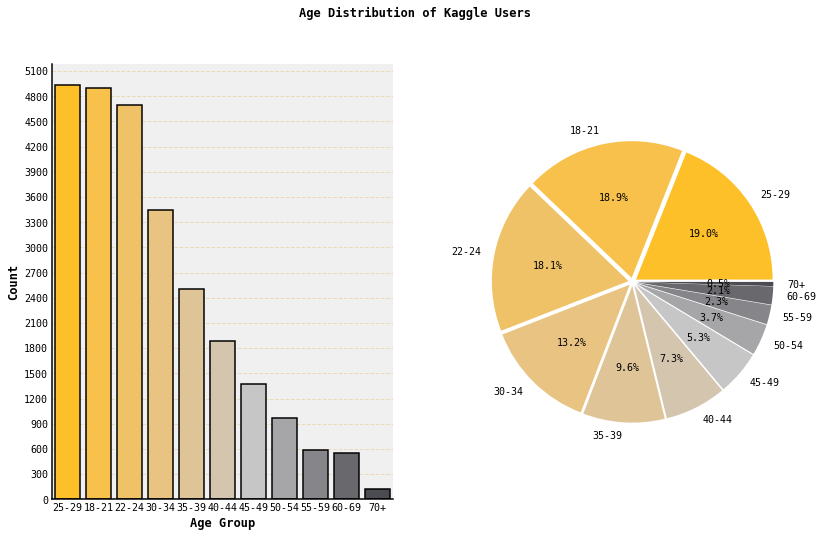

In [5]:
#Age

# plotting and styling
fig, ax = plt.subplots(1, 2, figsize=(12,8))
sns.barplot(x=df['What is your age (# years)?'].value_counts().index, y=df['What is your age (# years)?'].value_counts().values, palette=cust_color, ax=ax[0],
           edgecolor='black', linewidth=1.5, saturation=1.5)
ax[0].yaxis.set_major_locator(MaxNLocator(nbins=20))
ax[0].tick_params(axis='x', which='major', labelsize=10)
ax[0].set_ylabel('Count', weight='semibold', fontname = 'monospace')
ax[0].set_xlabel('Age Group', weight='semibold', fontname = 'monospace')



ax[1].pie(df['What is your age (# years)?'].value_counts(), labels = df['What is your age (# years)?'].value_counts().index, colors = cust_color, autopct='%1.1f%%',
        explode=[0.03 for i in df['What is your age (# years)?'].value_counts().index])


plt.suptitle('Age Distribution of Kaggle Users', fontname = 'monospace', weight='bold')
plt.show()

### *Gender*

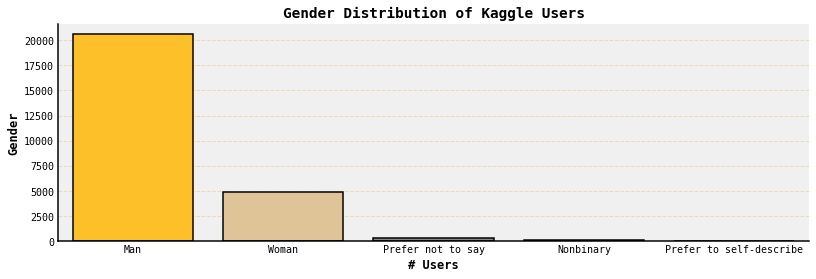

In [6]:
#gender distribution

# plotting and styling
fig, ax = plt.subplots(figsize=(12,4))
sns.barplot(x=df['What is your gender?'].value_counts().index, y=df['What is your gender?'].value_counts().values, palette=cust_color[::4], edgecolor='black', linewidth=1.5, saturation=1.5)
plt.xlabel("# Users", fontname = 'monospace', weight='semibold')
plt.ylabel("Gender", fontname = 'monospace', weight='semibold')
plt.title('Gender Distribution of Kaggle Users', fontname = 'monospace', weight='bold');

### *Platforms used to learn Data Science*

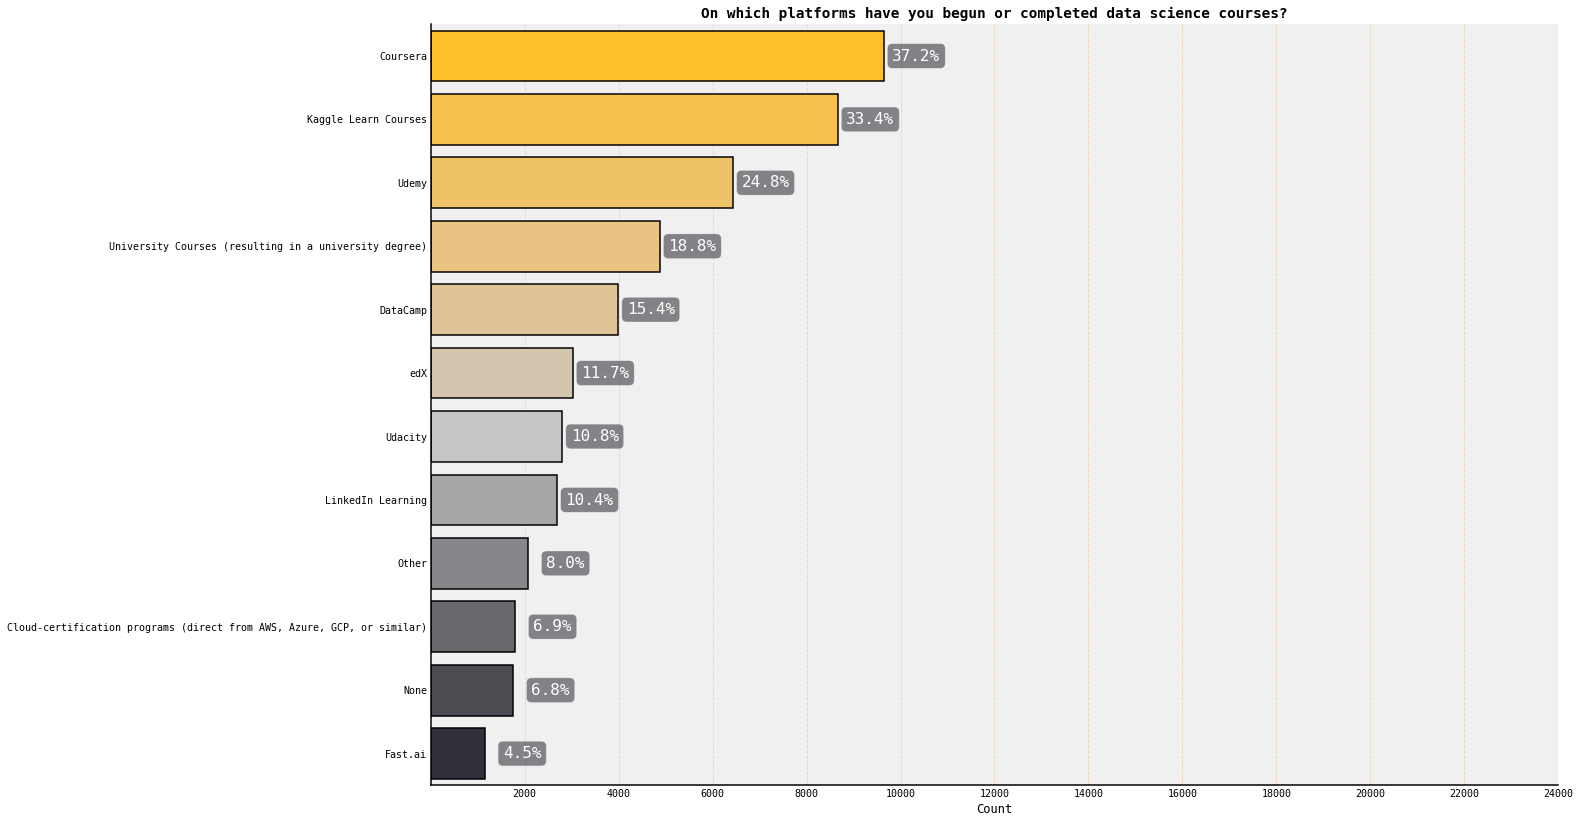

In [7]:
# Courses taken online for data science preparation

# getting course columns and plotting them
course_cols = [col.split('?')[-1].strip() for col in df.columns if "data science courses" in col]
crs=one_hot_count(df=df, values=course_cols, text="On which platforms have you begun or completed data science courses? ", colors=cust_color, shift_text=1200, x_freq=2000,
                 title="On which platforms have you begun or completed data science courses?", fontsize=16)

In [8]:
def count_dist(df, colname=None, fixlabel=False, f_axis=None, fixlabel_n=None, fixlabel_txt=None, max_idx=30, fontsize=12, palette=cust_color, rotation=45,
              title='X distribution of Kaggle Users', y_label='', shift=-0.005):
    """A function for counting and displaying categorical variables including percentage texts."""
    fig, ax = plt.subplots()
    sns.barplot(y=df[colname].value_counts().index[:max_idx],
                x=df[colname].value_counts().values[:max_idx], palette=palette, edgecolor='black', linewidth=1.5, saturation = 1.5)
    z=df[colname].value_counts().values[:max_idx]
    for n, i in enumerate(df[colname].value_counts().index[:max_idx]):    
        ax.text(df[colname].value_counts().values[:max_idx][n]+shift, 
                n, #Y location
                s=f'{round(z[n]/df.shape[0]*100,1)}%',                 
                va='center', 
                ha='right', 
                color='white', 
                fontsize=fontsize,
                bbox=dict(boxstyle='round',facecolor='black', alpha=0.5))
    if fixlabel:
        if f_axis == 'x':
            labels = [item.get_text() for item in ax.get_xticklabels()]
            labels[fixlabel_n] = fixlabel_txt
            ax.set_xticklabels(labels)
        else:
            labels = [item.get_text() for item in ax.get_yticklabels()]
            labels[fixlabel_n] = fixlabel_txt
            ax.set_yticklabels(labels)            

    plt.title(title, fontname = 'monospace', weight='bold')
    del z
    
    plt.yticks(fontsize=12,rotation=rotation)
    plt.xlabel("# Users", fontname = 'monospace', weight='semibold')
    plt.ylabel(y_label, fontname = 'monospace', weight='semibold')
    plt.show()

### *Organisation roles with respect to coding experience*

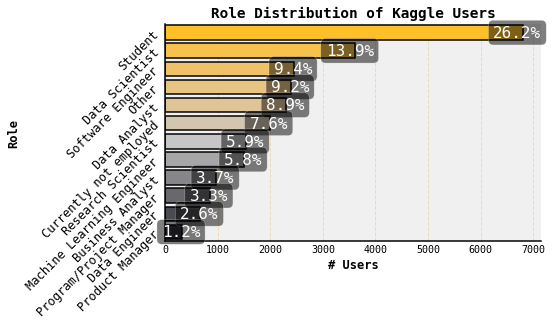

In [9]:
#what is the occupation of the survey participant

count_dist(df=df, colname='Select the title most similar to your current role (or most recent title if retired):',
           max_idx=12, fontsize=16, rotation=45, palette=cust_color,
           title='Role Distribution of Kaggle Users', shift=350, y_label = 'Role')

### *Coding experience of survey participants*

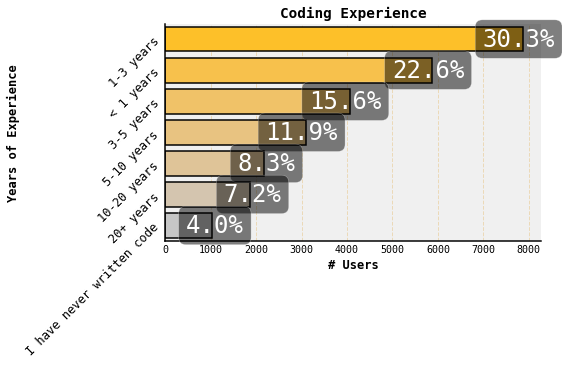

In [10]:
#coding experience of survey participants

count_dist(df=df, colname='For how many years have you been writing code and/or programming?',
           max_idx=30, fontsize=24, rotation=45,
           title='Coding Experience', shift=700, y_label='Years of Experience'
          )

### *Organisation roles with respect to coding experience*


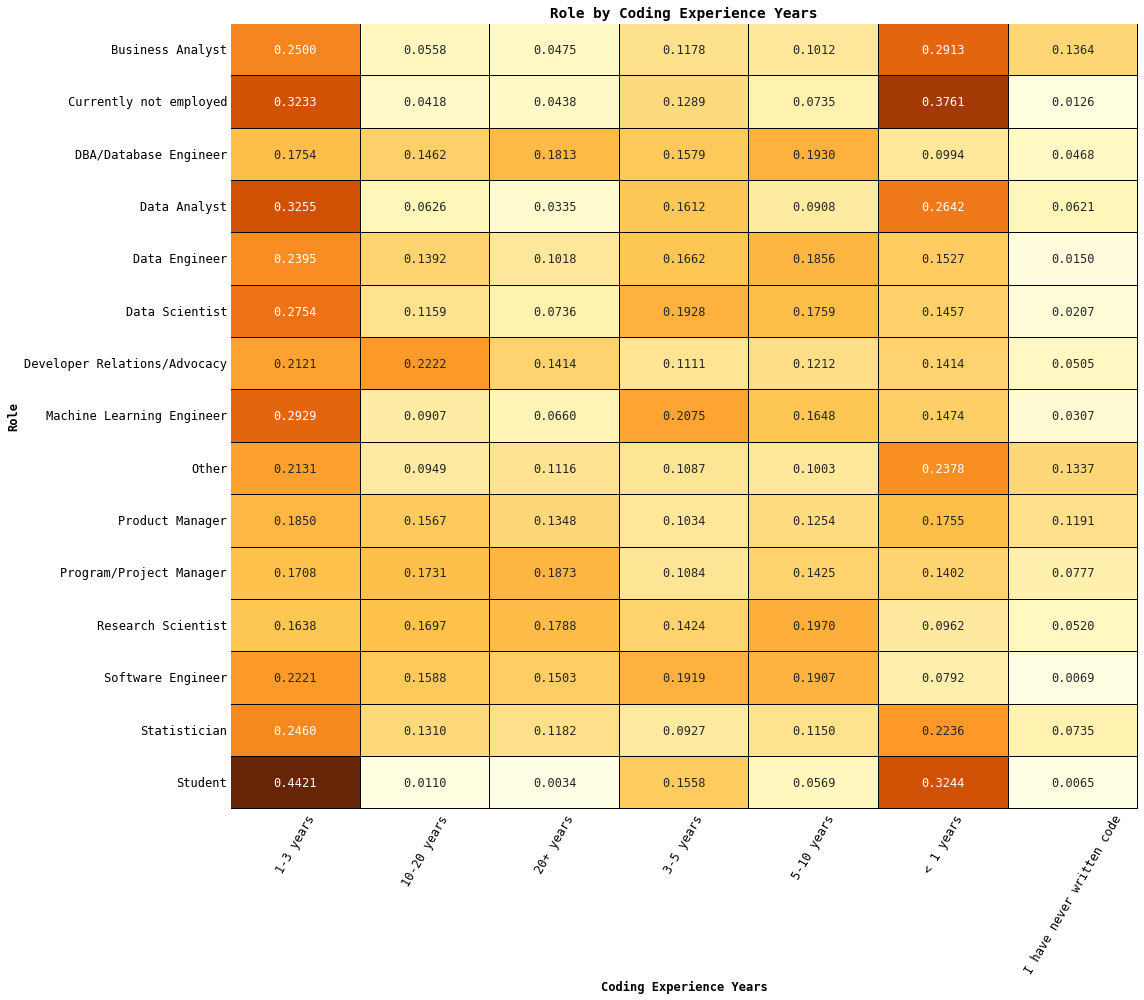

In [11]:
#Organisation roles with respect to coding experience

z=df.groupby(['Select the title most similar to your current role (or most recent title if retired):',
             'For how many years have you been writing code and/or programming?']).size().unstack().fillna(0).astype('int16')
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(z.apply(lambda x: x/x.sum(), axis=1), xticklabels=True, yticklabels=True, cmap='YlOrBr', annot=True, linewidths=0.005, linecolor='black', annot_kws={"fontsize":12}, fmt='.4f', cbar=False)
plt.title('Role by Coding Experience Years', fontname = 'monospace', weight='bold')
plt.xticks(fontsize=12,rotation=60)
plt.yticks(fontsize=12)
plt.xlabel('Coding Experience Years', fontname = 'monospace', weight='semibold')
plt.ylabel('Role', fontname = 'monospace', weight='semibold')
plt.tight_layout()
del z

### *Organisation roles with respect to particpants degree and coding experience*

In [12]:
# organisation roles with respect to particpants degree and coding experience

def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram', colors=None):
    # Source: https://www.kaggle.com/iyadavvaibhav/plotly-sankey-with-filters    
    # Don't forget to go and check his work :)
    colorPalette = colors
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    
    return fig

In [13]:
# plotting sankey
df['edu_cnt'] = df.groupby('Select the title most similar to your current role (or most recent title if retired):')['Select the title most similar to your current role (or most recent title if retired):'].transform('count')
sank = genSankey(df,cat_cols=['What is the highest level of formal education that you have attained or plan to attain within the next 2 years?','For how many years have you been writing code and/or programming?','Select the title most similar to your current role (or most recent title if retired):'],value_cols='edu_cnt',title='Education, Experience and Role', colors = cust_color[::4])
fig = go.Figure(sank)
fig.update_layout(margin=dict(t=35, l=20, r=20, b=20))
iplot(fig)

### *Popular programming languages for data science*

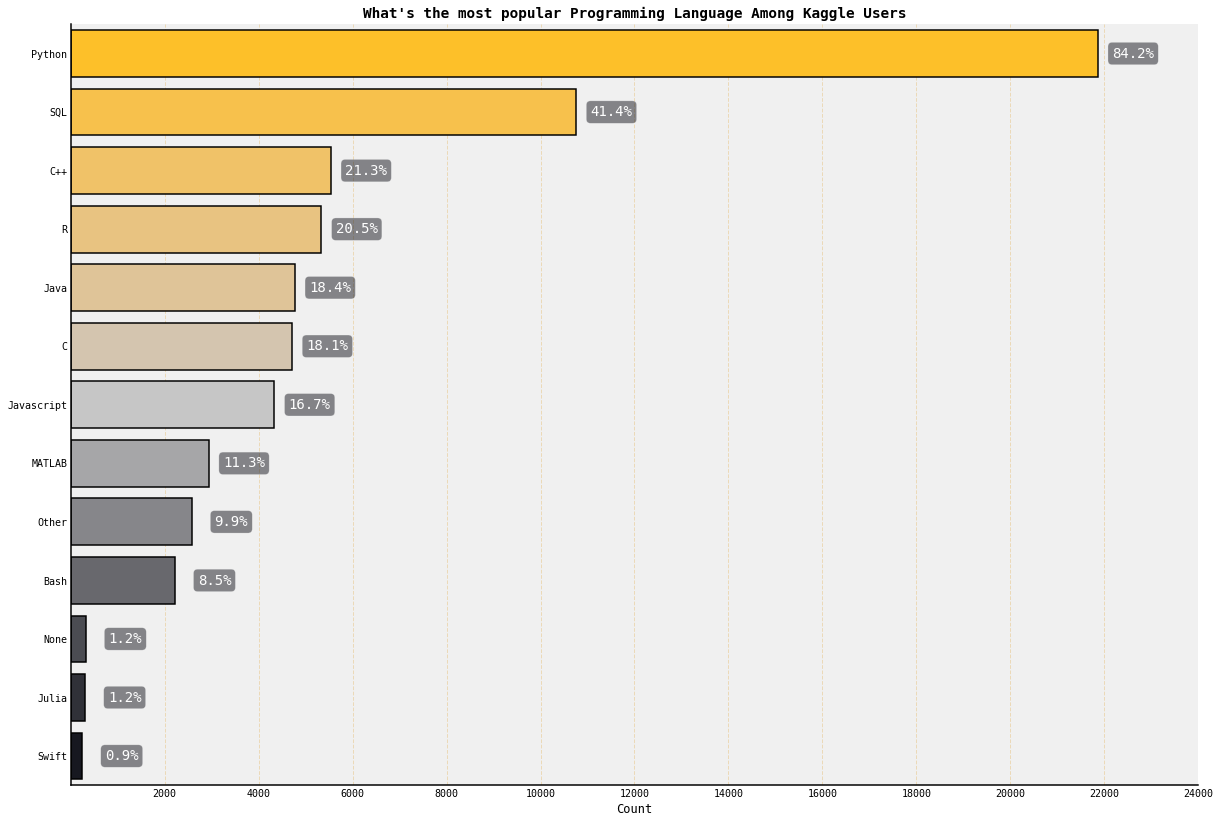

In [14]:
#popular programming languages for data science

languages = ['Python', 'R', 'SQL', 'C', 'C++', 'Java', 'Javascript', 'Julia', 'Swift', 'Bash', 'MATLAB', 'None', 'Other']

df2=one_hot_count(df=df, values=languages, text='What programming languages do you use on a regular basis? ', colors=cust_color, shift_text=1200, x_freq=2000,
                 title="What's the most popular Programming Language Among Kaggle Users", fontsize=14)

### *Programming langauage usage with respect to occupation*

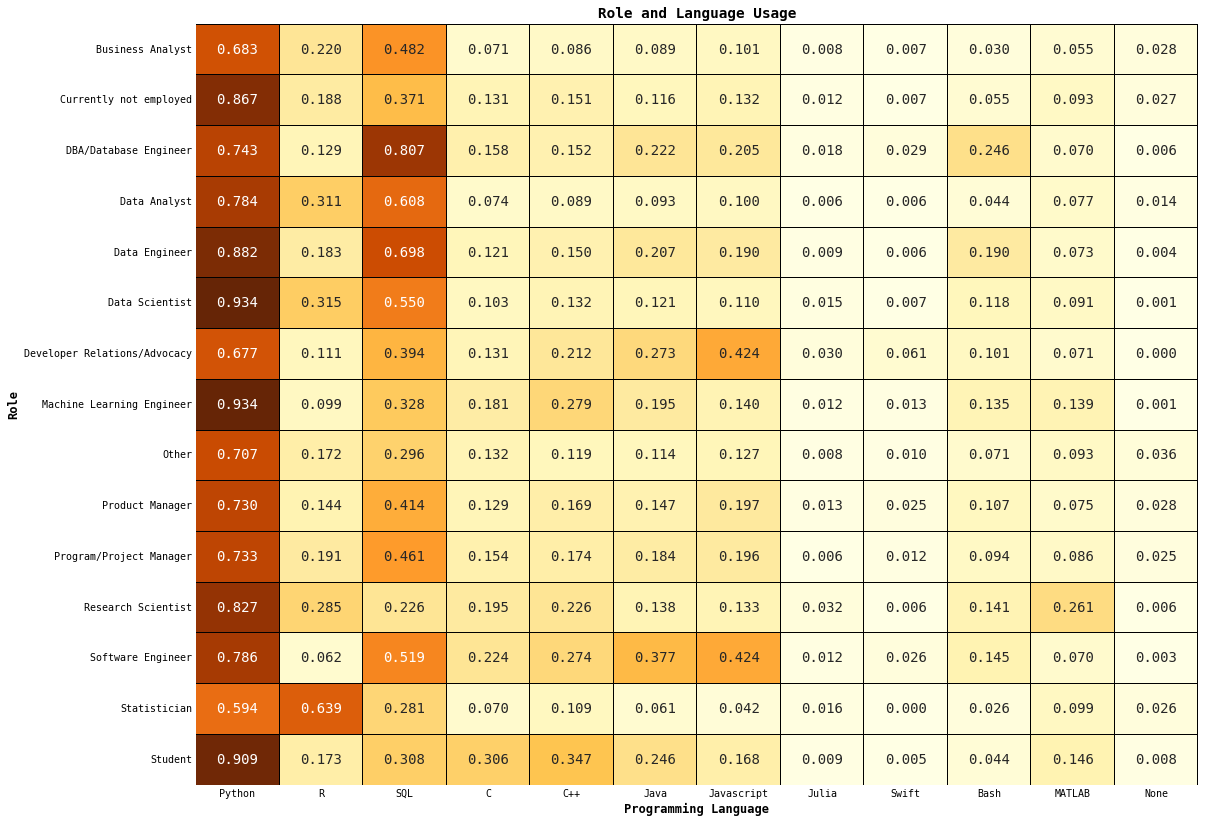

In [15]:
#Programming langauage usage with respect to occupation

# getting percentages and plotting them in styled heatmap
fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(df2.groupby('Select the title most similar to your current role (or most recent title if retired):').mean().iloc[:,1:-2],
            xticklabels=True, yticklabels=True, cmap='YlOrBr', annot=True, linewidths=0.005, linecolor='black', annot_kws={"fontsize":14}, fmt='.3f', cbar=False)
plt.title('Role and Language Usage', fontname = 'monospace', weight='bold')
plt.ylabel('Role', fontname = 'monospace', weight='semibold')
plt.xlabel('Programming Language', fontname = 'monospace', weight='semibold')
plt.show()

In [ ]:
'''
The Story of our little Robert would be something like this:

Robert is a 24 year old male from USA, he got his Bachelor's degree recently and planning to attend Master's program incoming years. He still identifies himself as a student. He's been interested in programming and data science lately but didn't have formal education to get to know about these in school. So he decided to learn programming from online courses on his own. He found out Python is very popular for Data Science and he started studying about it. After couple months of courses (1< years of experience) he feels competent enough to look at Data Science stuff using Python. He jumps on kaggle to play with toy datasets like Titanic, Housing Prices etc. He gets more familiar to work on kaggle (jupyter) notebooks but with all of the new stuff about data science pouring over him like Data Analysis, Machine Learning, Deep Learning Frameworks, Algorithms, CV/NLP, he gets little bit overwhelmed and lost... He doesn't know what to study and in which order he should start learning. Even he learns about some stuff, he still gets confused about his future job, is he going to be a Data Analyst? Data Scientist? Or Machine Learning Engineer? Or something else... He doesn't know, they all seem similar to him and with his background/skills he doesn't know which role he perfectly fits. What is going to be his daily work responsibilities, what does he need to know to fulfill his duties, what does he need to learn to advance in his career. Will his salary going to be satisfying for him, or did he make a mistake by choosing Data Science field? What if he made a bad decision, or he's going to make one? Robert gets stressed and confused lately... Maybe with help of the data itself we can help poor little Robert, shall we?
'''

### *Important machine learning algorithms for data science*

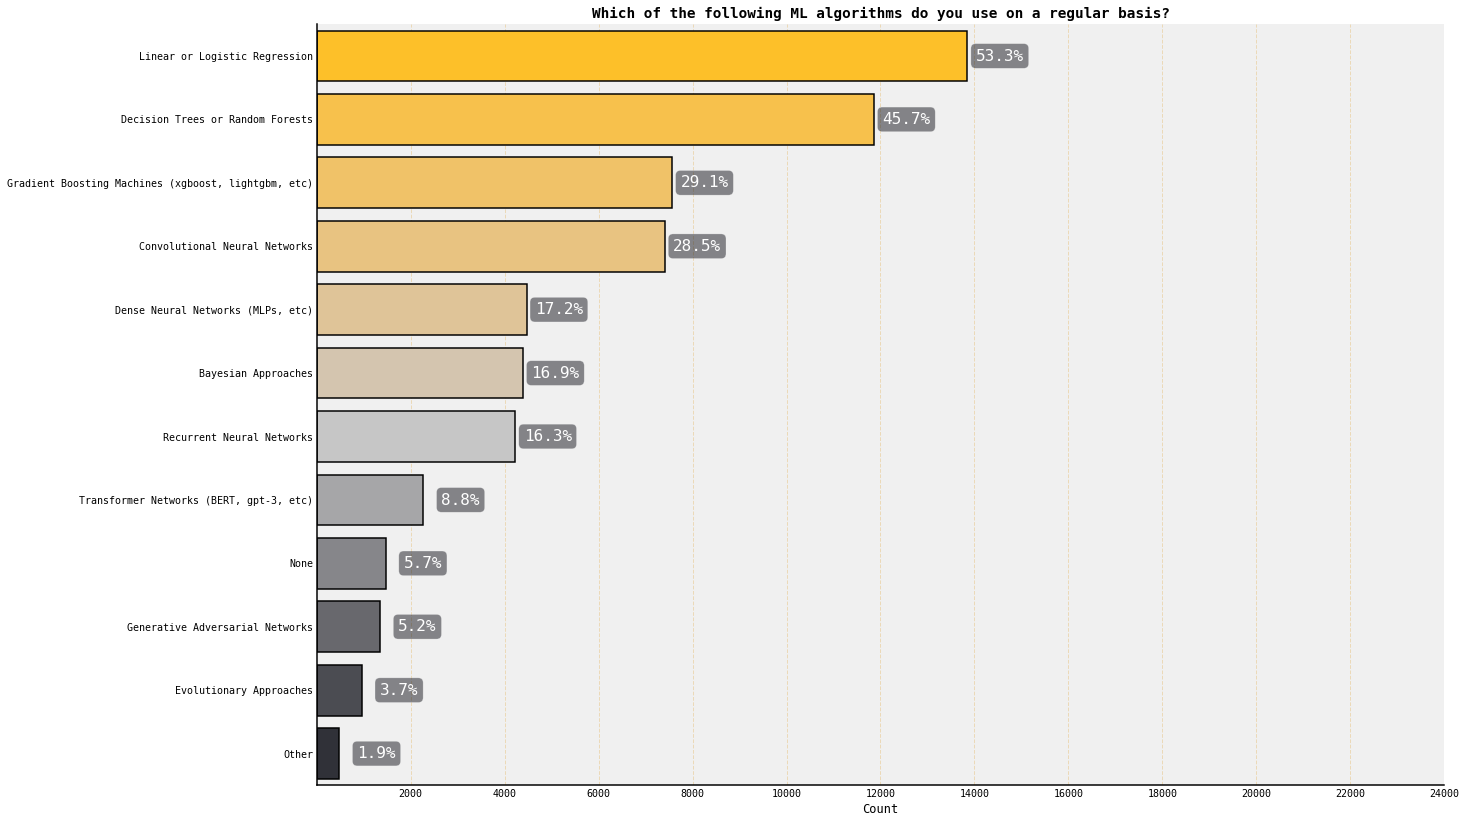

In [16]:
#important machine learning algorithms for data science

# setting multi choice algorithm column names as list and plotting them
alg_cols = [col.split('?')[-1].strip() for col in df.columns if "ML algorithms" in col]
df8=one_hot_count(df=df, values=alg_cols, text="Which of the following ML algorithms do you use on a regular basis? ", colors=cust_color, shift_text=1200, x_freq=2000,
                 title="Which of the following ML algorithms do you use on a regular basis?", fontsize=16)



### *Important data visualisation libraries for data science*

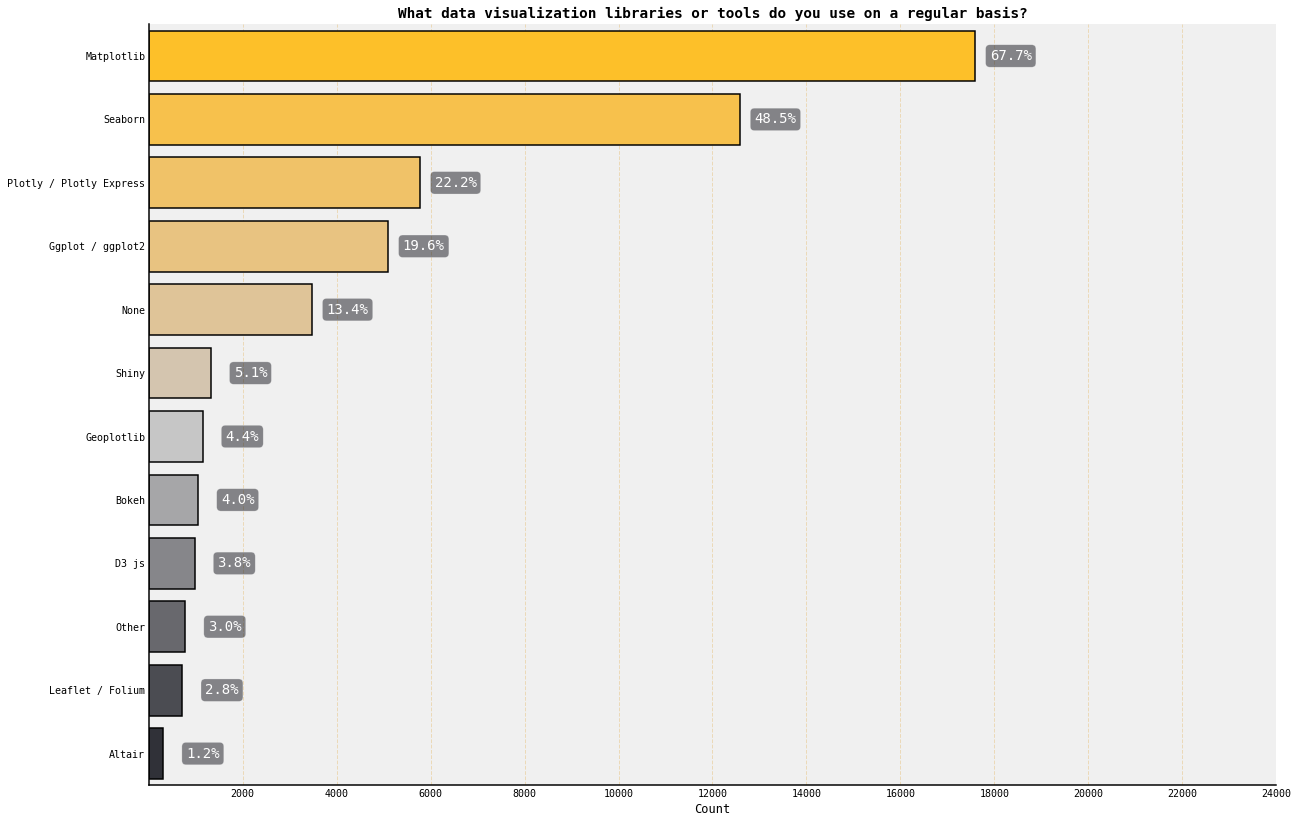

In [17]:
#important data visualisation libraries for data science

# setting multi choice visualization column names as list
visualization_cols = [col.split('?')[-1].strip() for col in df.columns if "visualization" in col]
df6=one_hot_count(df=df, values=visualization_cols, text="What data visualization libraries or tools do you use on a regular basis? ", colors=cust_color, shift_text=1200, x_freq=2000,
                 title="What data visualization libraries or tools do you use on a regular basis?", fontsize=14)

### *Tasks performed by data scientists at work*

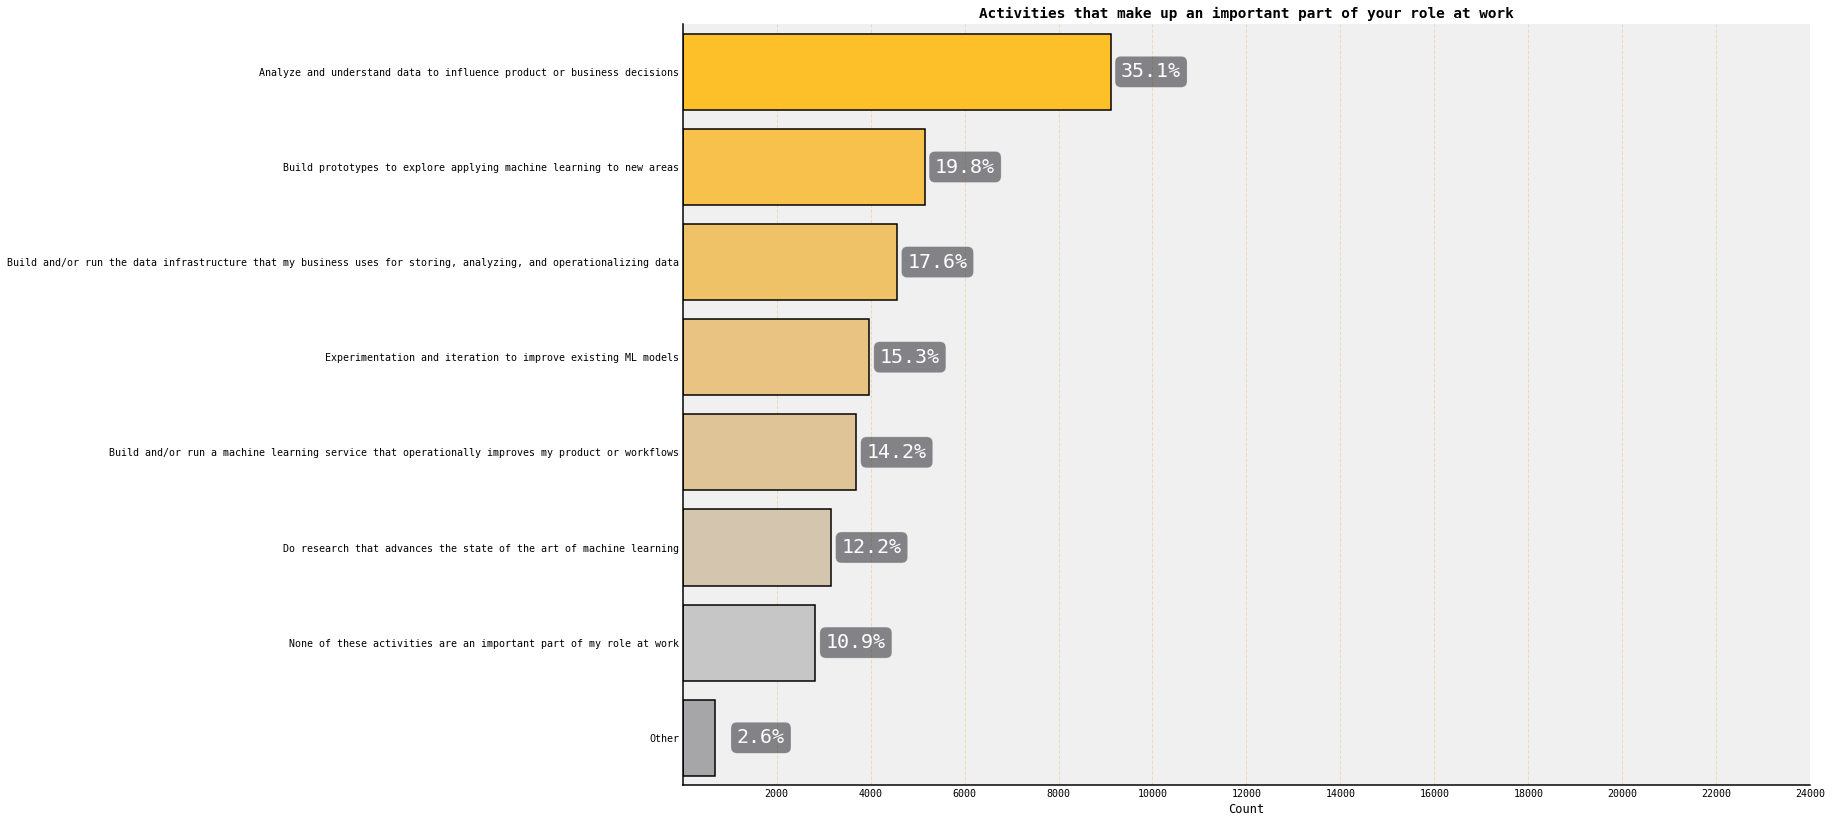

In [18]:
# tasks performed by data scientists at work
activities = [col.split(':')[-1].strip() for col in df.columns if "an important part" in col]
df10=one_hot_count(df=df, values=activities, text="Select any activities that make up an important part of your role at work: ", colors=cust_color, shift_text=1500, x_freq=2000,
                 title="Activities that make up an important part of your role at work", fontsize=20)

### *Yearly compensation of survey participants*

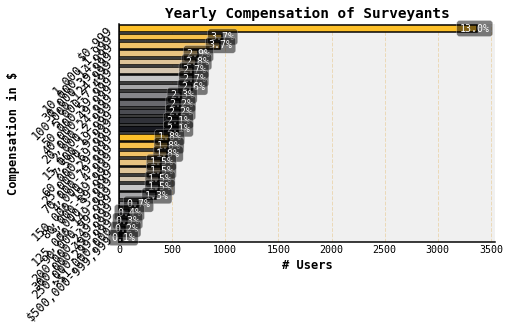

In [19]:
#yearly compensation of survey participants

count_dist(df=df, colname='What is your current yearly compensation (approximate $USD)?', max_idx=30, fontsize=10,
           rotation=45,
           title='Yearly Compensation of Surveyants', palette=cust_color, shift=120, y_label= 'Compensation in $')

In [ ]:
#salary prediction

In [20]:
df_sal = pd.read_csv('kaggle_survey_2021_responses.csv')
df_sal = df_sal[['Q1','Q3','Q4','Q5','Q6','Q25']]

new_header = df_sal.iloc[0] #grab the first row for the header
df_sal = df_sal[1:] #take the data less the header row
df_sal.columns = ['Age','Country','Degree','Role','Experience','Current_salary'] #set the header row as the df header
df_sal.head()



,Age,Country,Degree,Role,Experience,Current_salary
1,50-54,India,Bachelor’s degree,Other,5-10 years,"25,000-29,999"
2,50-54,Indonesia,Master’s degree,Program/Project Manager,20+ years,"60,000-69,999"
3,22-24,Pakistan,Master’s degree,Software Engineer,1-3 years,$0-999
4,45-49,Mexico,Doctoral degree,Research Scientist,20+ years,"30,000-39,999"
5,45-49,India,Doctoral degree,Other,< 1 years,"30,000-39,999"


In [21]:
df_sal['Experience'].replace(['5-10 years', '20+ years', '1-3 years', '< 1 years', '3-5 years',
       '10-20 years', 'I have never written code'],
                        [0,1, 2,3,4,5,6], inplace=True)
df_sal.head()

,Age,Country,Degree,Role,Experience,Current_salary
1,50-54,India,Bachelor’s degree,Other,0,"25,000-29,999"
2,50-54,Indonesia,Master’s degree,Program/Project Manager,1,"60,000-69,999"
3,22-24,Pakistan,Master’s degree,Software Engineer,2,$0-999
4,45-49,Mexico,Doctoral degree,Research Scientist,1,"30,000-39,999"
5,45-49,India,Doctoral degree,Other,3,"30,000-39,999"


In [22]:
df_sal['Role'].replace(['Other', 'Program/Project Manager', 'Software Engineer',
       'Research Scientist', 'Currently not employed', 'Student',
       'Data Scientist', 'Data Analyst', 'Machine Learning Engineer',
       'Business Analyst', 'Data Engineer', 'Product Manager',
       'Statistician', 'Developer Relations/Advocacy',
       'DBA/Database Engineer'],
        [0,1, 2,3,4,5,6,7,8,9,10,11,12,13,14], inplace=True)
df_sal.head()

,Age,Country,Degree,Role,Experience,Current_salary
1,50-54,India,Bachelor’s degree,0,0,"25,000-29,999"
2,50-54,Indonesia,Master’s degree,1,1,"60,000-69,999"
3,22-24,Pakistan,Master’s degree,2,2,$0-999
4,45-49,Mexico,Doctoral degree,3,1,"30,000-39,999"
5,45-49,India,Doctoral degree,0,3,"30,000-39,999"


In [23]:
df_sal['Degree'].replace(['Bachelor’s degree', 'Master’s degree', 'Doctoral degree',
       'I prefer not to answer',
       'Some college/university study without earning a bachelor’s degree',
       'No formal education past high school', 'Professional doctorate'],
         [0,1, 2,3,4,5,6], inplace=True)
df_sal.head()

,Age,Country,Degree,Role,Experience,Current_salary
1,50-54,India,0,0,0,"25,000-29,999"
2,50-54,Indonesia,1,1,1,"60,000-69,999"
3,22-24,Pakistan,1,2,2,$0-999
4,45-49,Mexico,2,3,1,"30,000-39,999"
5,45-49,India,2,0,3,"30,000-39,999"


In [24]:
df_sal['Age'].replace(['50-54', '22-24', '45-49', '25-29', '18-21', '30-34', '40-44',
       '35-39', '70+', '55-59', '60-69'],
          [0,1, 2,3,4,5,6,7,8,9,10], inplace=True)
df_sal.head()

,Age,Country,Degree,Role,Experience,Current_salary
1,0,India,0,0,0,"25,000-29,999"
2,0,Indonesia,1,1,1,"60,000-69,999"
3,1,Pakistan,1,2,2,$0-999
4,2,Mexico,2,3,1,"30,000-39,999"
5,2,India,2,0,3,"30,000-39,999"


In [25]:
df_sal = df_sal.merge(pd.get_dummies(df_sal.Country, prefix='Country'), left_index=True, right_index=True)
del df_sal['Country']


In [26]:
df_sal['Current_salary'] = df_sal['Current_salary'].str.replace(',','').str.replace('$','')


In [27]:
salary_cats = [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
salary_cat_values = ['25000-29999', '60000-69999', '0-999', '30000-39999', np.nan,
       '15000-19999', '70000-79999', '2000-2999', '10000-14999',
       '5000-7499', '20000-24999', '1000-1999', '100000-124999',
       '7500-9999', '4000-4999', '40000-49999', '50000-59999',
       '3000-3999', '300000-499999', '200000-249999', '125000-149999',
       '250000-299999', '80000-89999', '90000-99999', '150000-199999',
       '>1000000', '500000-999999']
salary_dict = dict(zip(salary_cats,salary_cat_values))

df_sal['Current_salary'].replace(['25000-29999', '60000-69999', '0-999', '30000-39999', np.nan,
       '15000-19999', '70000-79999', '2000-2999', '10000-14999',
       '5000-7499', '20000-24999', '1000-1999', '100000-124999',
       '7500-9999', '4000-4999', '40000-49999', '50000-59999',
       '3000-3999', '300000-499999', '200000-249999', '125000-149999',
       '250000-299999', '80000-89999', '90000-99999', '150000-199999',
       '>1000000', '500000-999999'],
          [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], inplace=True)
df_sal['Current_salary'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from xgboost import XGBRegressor, plot_importance 



In [29]:
y = df_sal["Current_salary"].values
X = df_sal.drop("Current_salary",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

In [30]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb.fit(X_train, y_train)
y_hat = xgb.predict(X_test)

[23:59:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

In [ ]:
xgb.score(X_test,y_test)

In [ ]:
########################################################
######## IMPORTING NECESSARY MODULES AND MODELS ########
########################################################

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_


In [ ]:
y_hat_Search = rf_random.predict(X_test)

In [ ]:
print("XGBoost Regressor R2-score: {}".format(round(r2_score(y_hat, y_test),4)))
print("RandomForest Regressor Prediction R2-score: {}".format(round(r2_score(y_hat_Search, y_test),4)))
print("\nMSE of XGBoost Regressor: {}".format(median_absolute_error(y_hat, y_test)))
print("MSE of RandomForest Regressor: {} ".format(median_absolute_error(y_hat_Search, y_test)))